In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Audio Embeddings

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math


class BreathDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # Create a mapping from label strings to integers
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract embedding and label
        # Check if 'embedding' is a list, if not wrap in list:
        embedding = self.data.iloc[idx]['embedding']
        embedding = embedding if isinstance(embedding, list) else [embedding]
        embedding = np.array(embedding[0])  # Shape (T, D)

        label_str = self.data.iloc[idx]['label']
        label = self.label_to_index[label_str]

        return torch.tensor(embedding, dtype=torch.float32), label
def collate_fn(batch):
    embeddings, labels = zip(*batch)
    lengths = [emb.shape[0] for emb in embeddings]
    max_len = max(lengths)
    d_model = embeddings[0].shape[1]

    padded_embeddings = torch.zeros(len(embeddings), max_len, d_model)
    attention_mask = torch.zeros(len(embeddings), max_len)

    for i, emb in enumerate(embeddings):
        padded_embeddings[i, :emb.shape[0], :] = emb
        attention_mask[i, :emb.shape[0]] = 1

    labels = torch.tensor(labels, dtype=torch.long)  # CORRECT dtype for multi-class
    return padded_embeddings, attention_mask, labels


In [ ]:
import torch
import math

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=6000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class BreathClassifier(torch.nn.Module):
    def __init__(self, d_model=768, nhead=8, dim_feedforward=3072, num_layers=2, num_classes=8):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(d_model, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, num_classes)  # 5 output logits
        )

    def forward(self, src, src_mask):
        src = self.pos_encoder(src)
        output = self.transformer(src, src_key_padding_mask=(src_mask == 0))

        # Masked mean pooling
        masked_output = output * src_mask.unsqueeze(-1)
        pooled = masked_output.sum(dim=1) / src_mask.sum(dim=1, keepdim=True)

        return self.classifier(pooled)  # Return raw logits


In [ ]:
import os
import noisereduce as nr

In [ ]:
!pip install noisereduce

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
import pandas as pd
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm

# Configuration
AUDIO_DIR = "/content/drive/MyDrive/ICBHI_final_database/augmented_audio"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_RATE = 16000  # Wav2Vec expects 16kHz audio

# Initialize Wav2Vec model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

def extract_label_from_filename(filename):
    """Extract class label from filename (part before first underscore)"""
    return filename.split('_')[0]

def load_and_resample_audio(filepath, target_sample_rate=SAMPLE_RATE):
    """Load audio file and resample to target rate"""
    waveform, sample_rate = torchaudio.load(filepath)
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
        waveform = resampler(waveform)
    return waveform.squeeze(), target_sample_rate

def get_wav2vec_embedding(waveform, sample_rate):
    """Generate Wav2Vec embedding for audio waveform"""
    # Process the audio
    inputs = processor(waveform, sampling_rate=sample_rate, return_tensors="pt", padding=True)

    # Move to device and get embeddings
    with torch.no_grad():
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = model(**inputs)

    # Use last hidden state as embedding (mean across time dimension)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

def process_audio_folder(folder_path):
    """Process all audio files in folder and return DataFrame with embeddings"""
    data = []

    # Get all audio files in folder
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac'))]

    for filename in tqdm(audio_files, desc="Processing audio files"):
        try:
            # Extract label from filename
            label = extract_label_from_filename(filename)

            # Load and resample audio
            filepath = os.path.join(folder_path, filename)
            waveform, sample_rate = load_and_resample_audio(filepath)

            # Get embedding
            embedding = get_wav2vec_embedding(waveform, sample_rate)

            # Store results
            data.append({
                'filename': filename,
                'label': label,
                'embedding': embedding
            })

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

    # Create DataFrame
    df = pd.DataFrame(data)
    return df




Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
df = process_audio_folder(AUDIO_DIR)

Processing audio files: 100%|██████████| 5424/5424 [05:33<00:00, 16.26it/s]


In [ ]:
df.head()

,filename,label,embedding
0,Pneumonia_a6955fdf-95e7-4b2b-b330-698d7edf7570...,Pneumonia,"[-0.097510636, 4.2655134e-05, 0.19959599, -0.0..."
1,Pneumonia_90fd82d2-6000-4134-80a0-baf295e579aa...,Pneumonia,"[-0.034101635, -0.042979248, 0.13154723, -0.05..."
2,Pneumonia_e755981e-9f12-472c-8222-26fcc55585a7...,Pneumonia,"[-0.01728759, -0.016486688, 0.048547518, -0.03..."
3,Pneumonia_8baffdfd-9725-4fe9-87d7-a07fa7a118c5...,Pneumonia,"[0.026638981, 0.016866552, -0.00025290376, -0...."
4,Pneumonia_fbe6a898-3963-4e77-b626-996bd4ec92ff...,Pneumonia,"[-0.044059437, -0.026904853, 0.09366725, -0.05..."


In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:

def load_data_and_create_dataframe(embeddings_folder, labels_file):
    # Step 1: Load labels from text file
    labels_df = pd.read_csv(labels_file, sep='\t', header=None, names=['id', 'label'])

    # Create a dictionary mapping from ID to label
    id_to_label = dict(zip(labels_df['id'], labels_df['label']))

    # Step 2: Initialize lists to store data
    embeddings = []
    file_names = []
    labels = []
    ids = []

    # Step 3: Process each .npy file in the embeddings folder
    for file in os.listdir(embeddings_folder):
        if file.endswith('.npy'):
            # Extract ID from filename (assuming format like "154_3b3_Ar_mc_AKGC417L.npy")
            file_id = int(file.split('_')[0])

            # Get the corresponding label
            if file_id in id_to_label:
                label = id_to_label[file_id]
                # Load the embedding
                embedding = np.load(os.path.join(embeddings_folder, file))

                # Store the data
                embeddings.append(embedding)
                file_names.append(file)
                labels.append(label)
                ids.append(file_id)
            else:
                print(f"Warning: No label found for ID {file_id} in file {file}")

    # Step 4: Create DataFrame
    data = {
        'id': ids,
        'file_name': file_names,

        'embedding': embeddings,
        'label': labels
    }

    df = pd.DataFrame(data)

    return df


In [ ]:
embeddings_folder = '/content/drive/MyDrive/ICBHI_final_database/embeddings_npy'
labels_file = '/content/drive/MyDrive/ICBHI_final_database/labels.txt'

df = load_data_and_create_dataframe(embeddings_folder, labels_file)



In [ ]:
def load_name_to_dataframe(embedding_dir):
    labels_df = pd.read_csv(labels_file, sep='\t', header=None, names=['id', 'label'])

    # Create a dictionary mapping from ID to label
    id_to_label = dict(zip(labels_df['id'], labels_df['label']))

    data = []
    for root, _, files in os.walk(embedding_dir):
        for file in files:
            if file.endswith(".wav"):
                file_id = int(file.split('_')[0])
                label = id_to_label[file_id]
                file_path = os.path.join(root, file)
                data.append({
                    "id": file_id,
                    "file_path": file_path,
                    "label": label
                })

    df = pd.DataFrame(data)
    return df

In [ ]:
df_names = load_name_to_dataframe("/content/drive/MyDrive/ICBHI_final_database/ICBHI_final_database")

In [ ]:
df_names['file_path'][0]

'/content/drive/MyDrive/ICBHI_final_database/ICBHI_final_database/204_2b5_Al_mc_AKGC417L.wav'

In [ ]:
df_train = df[['label','embedding']]

In [ ]:
%pip install audiomentations torchaudio librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s e

## Data Augmentation

In [ ]:
import torch
import torchaudio
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import random
import pandas as pd
from tqdm import tqdm
import uuid
# Setup Wav2Vec model
bundle = torchaudio.pipelines.WAV2VEC2_BASE
model = bundle.get_model().to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Wav2Vec expects 16kHz mono audio
sample_rate = bundle.sample_rate

# Setup audio augmentations
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5),
])

def extract_embedding(audio_tensor):
    with torch.no_grad():
        if audio_tensor.dim() == 1:
            audio_tensor = audio_tensor.unsqueeze(0)
        # Get the device from the model's parameters:
        device = next(model.parameters()).device
        return model.extract_features(audio_tensor.to(device))[0][0].cpu().numpy()

def augment_and_balance(df, audio_path_column='file_path', label_column='label', output_dir='/content/drive/MyDrive/ICBHI_final_database/augmented_audio'):
    os.makedirs(output_dir, exist_ok=True)

    label_counts = df[label_column].value_counts()
    max_count = label_counts.max()
    balanced_rows = []

    for label, count in label_counts.items():
        rows = df[df[label_column] == label]
        balanced_rows.extend(rows.to_dict(orient="records"))

        if count < max_count:
            augment_needed = max_count - count
            for _ in tqdm(range(augment_needed), desc=f"Augmenting '{label}'"):
                row = rows.sample(1).iloc[0]
                audio, sr = torchaudio.load(row[audio_path_column])
                audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=sample_rate)

                augmented = augment(samples=audio.squeeze().numpy(), sample_rate=sample_rate)
                augmented_tensor = torch.tensor(augmented).unsqueeze(0)  # (1, T)

                # Save augmented waveform
                file_id = str(uuid.uuid4())
                output_path = os.path.join(output_dir, f"{label}_{file_id}.wav")
                torchaudio.save(output_path, augmented_tensor, sample_rate=sample_rate)

                # Extract embedding
                embedding = extract_embedding(augmented_tensor.squeeze(0))

                # Store in dataframe
                balanced_rows.append({
                    'embedding': [embedding],
                    'label': label,
                    'filepath': output_path  # New path to saved audio
                })

    return pd.DataFrame(balanced_rows)


In [ ]:
df['file_path'][0]

'/content/drive/MyDrive/ICBHI_final_database/embeddings_npy'

In [ ]:
df_balanced = augment_and_balance(df_names, audio_path_column='file_path', label_column='label')

Augmenting 'Asthma': 100%|██████████| 792/792 [02:22<00:00,  5.55it/s]


In [ ]:
df_balanced['label'].value_counts()

,count
label,
COPD,793
Pneumonia,793
Healthy,793
URTI,793
Bronchiectasis,793
Bronchiolitis,793
LRTI,793
Asthma,793


In [ ]:
df_train.head()

,label,embedding
0,5,"[-0.097510636, 4.2655134e-05, 0.19959599, -0.0..."
1,5,"[-0.034101635, -0.042979248, 0.13154723, -0.05..."
2,5,"[-0.01728759, -0.016486688, 0.048547518, -0.03..."
3,5,"[0.026638981, 0.016866552, -0.00025290376, -0...."
4,5,"[-0.044059437, -0.026904853, 0.09366725, -0.05..."


In [ ]:
df_train['embedding'][0].shape


(768,)

In [ ]:
df_train

In [ ]:
# prompt: convert label to index using label encorder

from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame with a 'label' column
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])


print(label_encoder.classes_) # This will show you which number corresponds to which label
df_train.head()


['Asthma' 'Bronchiectasis' 'Bronchiolitis' 'Healthy' 'LRTI' 'Pneumonia'
 'URTI']


<ipython-input-13-5744c9eb8d67>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label'] = label_encoder.fit_transform(df_train['label'])


,label,embedding
0,5,"[-0.097510636, 4.2655134e-05, 0.19959599, -0.0..."
1,5,"[-0.034101635, -0.042979248, 0.13154723, -0.05..."
2,5,"[-0.01728759, -0.016486688, 0.048547518, -0.03..."
3,5,"[0.026638981, 0.016866552, -0.00025290376, -0...."
4,5,"[-0.044059437, -0.026904853, 0.09366725, -0.05..."


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class AudioTransformerClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=8, num_layers=4, num_heads=8):
        super().__init__()

        # Projection layer to match transformer's expected dimension
        self.projection = nn.Linear(input_dim, hidden_dim)

        # Transformer configuration
        config = BertConfig(
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim*4,
            max_position_embeddings=512,  # Can be adjusted
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1
        )

        # Transformer encoder
        self.transformer = BertModel(config)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, embedding_dim)

        # Add sequence dimension (batch_size, 1, embedding_dim)
        x = x.unsqueeze(1)

        # Project to hidden dimension
        x = self.projection(x)

        # Transformer expects (batch_size, seq_len, hidden_dim)
        transformer_output = self.transformer(inputs_embeds=x)

        # Get the [CLS] token equivalent (mean pooling in our case)
        pooled_output = transformer_output.last_hidden_state.mean(dim=1)

        # Classify
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
class AudioEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.labels = pd.get_dummies(dataframe['label']).values
        self.embeddings = np.stack(dataframe['embedding'].values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embedding, label

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def train_model_with_plots(train_dataset, val_dataset, num_epochs=20, batch_size=32, learning_rate=3e-5):
    # Initialize tracking
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'all_true': [],
        'all_preds': []
    }

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AudioTransformerClassifier().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for embeddings, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(embeddings)
            loss = criterion(outputs, labels.argmax(dim=1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

        scheduler.step()
        train_acc = 100. * correct / total
        train_loss = train_loss / len(train_loader)

        # Validation
        val_acc, val_loss, val_true, val_preds = evaluate(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['all_true'].extend(val_true)
        history['all_preds'].extend(val_preds)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    # Generate plots
    generate_evaluation_plots(history, class_names=train_dataset.data['label'].unique())

    return model, history

def evaluate(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_true = []
    all_preds = []

    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels.argmax(dim=1))

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.argmax(dim=1)).sum().item()

            all_true.extend(labels.argmax(dim=1).cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_acc = 100. * correct / total
    val_loss = val_loss / len(data_loader)
    return val_acc, val_loss, all_true, all_preds

In [ ]:
def generate_evaluation_plots(history, class_names):
    plt.figure(figsize=(15, 10))

    # 1. Training & Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Training & Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # 3. Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(history['all_true'], history['all_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # 4. Classification Report
    plt.subplot(2, 2, 4)
    report = classification_report(history['all_true'], history['all_preds'],
                                 target_names=class_names, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Greens')
    plt.title('Classification Report')
    plt.tight_layout()

    plt.savefig('training_evaluation.png')
    plt.show()

    # 5. Learning Curves (separate plot)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig('learning_curves.png')
    plt.show()

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
train_dataset = AudioEmbeddingDataset(df_train)
val_dataset = AudioEmbeddingDataset(df_val)



Epoch 1/50: 100%|██████████| 136/136 [00:02<00:00, 64.02it/s]


Epoch 1: Train Loss: 1.9276, Train Acc: 21.85% | Val Loss: 1.8367, Val Acc: 35.02%


Epoch 2/50: 100%|██████████| 136/136 [00:01<00:00, 80.31it/s]


Epoch 2: Train Loss: 1.7307, Train Acc: 35.05% | Val Loss: 1.5683, Val Acc: 41.11%


Epoch 3/50: 100%|██████████| 136/136 [00:01<00:00, 78.53it/s]


Epoch 3: Train Loss: 1.5007, Train Acc: 43.79% | Val Loss: 1.4620, Val Acc: 44.79%


Epoch 4/50: 100%|██████████| 136/136 [00:02<00:00, 67.36it/s]


Epoch 4: Train Loss: 1.3612, Train Acc: 49.00% | Val Loss: 1.3101, Val Acc: 50.51%


Epoch 5/50: 100%|██████████| 136/136 [00:01<00:00, 77.60it/s]


Epoch 5: Train Loss: 1.2455, Train Acc: 53.70% | Val Loss: 1.2099, Val Acc: 56.59%


Epoch 6/50: 100%|██████████| 136/136 [00:02<00:00, 67.41it/s]


Epoch 6: Train Loss: 1.1653, Train Acc: 57.50% | Val Loss: 1.1346, Val Acc: 58.43%


Epoch 7/50: 100%|██████████| 136/136 [00:02<00:00, 67.76it/s]


Epoch 7: Train Loss: 1.0959, Train Acc: 59.07% | Val Loss: 1.0971, Val Acc: 60.09%


Epoch 8/50: 100%|██████████| 136/136 [00:01<00:00, 71.19it/s]


Epoch 8: Train Loss: 1.0382, Train Acc: 61.95% | Val Loss: 1.0386, Val Acc: 63.50%


Epoch 9/50: 100%|██████████| 136/136 [00:01<00:00, 70.27it/s]


Epoch 9: Train Loss: 0.9906, Train Acc: 64.14% | Val Loss: 0.9912, Val Acc: 63.59%


Epoch 10/50: 100%|██████████| 136/136 [00:01<00:00, 71.46it/s]


Epoch 10: Train Loss: 0.9411, Train Acc: 65.61% | Val Loss: 0.9387, Val Acc: 66.08%


Epoch 11/50: 100%|██████████| 136/136 [00:01<00:00, 77.09it/s]


Epoch 11: Train Loss: 0.9150, Train Acc: 66.58% | Val Loss: 0.9519, Val Acc: 66.82%


Epoch 12/50: 100%|██████████| 136/136 [00:01<00:00, 78.36it/s]


Epoch 12: Train Loss: 0.8818, Train Acc: 67.87% | Val Loss: 0.8687, Val Acc: 68.94%


Epoch 13/50: 100%|██████████| 136/136 [00:01<00:00, 76.05it/s]


Epoch 13: Train Loss: 0.8595, Train Acc: 68.15% | Val Loss: 0.8788, Val Acc: 69.40%


Epoch 14/50: 100%|██████████| 136/136 [00:01<00:00, 73.28it/s]


Epoch 14: Train Loss: 0.8248, Train Acc: 69.60% | Val Loss: 0.8429, Val Acc: 70.05%


Epoch 15/50: 100%|██████████| 136/136 [00:01<00:00, 70.65it/s]


Epoch 15: Train Loss: 0.7883, Train Acc: 70.82% | Val Loss: 0.8608, Val Acc: 69.95%


Epoch 16/50: 100%|██████████| 136/136 [00:02<00:00, 66.56it/s]


Epoch 16: Train Loss: 0.7792, Train Acc: 70.13% | Val Loss: 0.8593, Val Acc: 69.68%


Epoch 17/50: 100%|██████████| 136/136 [00:01<00:00, 77.39it/s]


Epoch 17: Train Loss: 0.7471, Train Acc: 72.44% | Val Loss: 0.7810, Val Acc: 71.24%


Epoch 18/50: 100%|██████████| 136/136 [00:01<00:00, 74.33it/s]


Epoch 18: Train Loss: 0.7261, Train Acc: 73.04% | Val Loss: 0.8127, Val Acc: 70.23%


Epoch 19/50: 100%|██████████| 136/136 [00:01<00:00, 72.33it/s]


Epoch 19: Train Loss: 0.7001, Train Acc: 74.35% | Val Loss: 0.8353, Val Acc: 69.95%


Epoch 20/50: 100%|██████████| 136/136 [00:01<00:00, 78.25it/s]


Epoch 20: Train Loss: 0.7007, Train Acc: 73.93% | Val Loss: 0.7667, Val Acc: 72.35%


Epoch 21/50: 100%|██████████| 136/136 [00:01<00:00, 78.42it/s]


Epoch 21: Train Loss: 0.6739, Train Acc: 75.02% | Val Loss: 0.7576, Val Acc: 73.27%


Epoch 22/50: 100%|██████████| 136/136 [00:01<00:00, 79.32it/s]


Epoch 22: Train Loss: 0.6707, Train Acc: 74.56% | Val Loss: 0.7542, Val Acc: 71.98%


Epoch 23/50: 100%|██████████| 136/136 [00:01<00:00, 79.05it/s]


Epoch 23: Train Loss: 0.6410, Train Acc: 76.54% | Val Loss: 0.7711, Val Acc: 72.35%


Epoch 24/50: 100%|██████████| 136/136 [00:01<00:00, 72.52it/s]


Epoch 24: Train Loss: 0.6375, Train Acc: 76.61% | Val Loss: 0.7674, Val Acc: 72.72%


Epoch 25/50: 100%|██████████| 136/136 [00:01<00:00, 77.11it/s]


Epoch 25: Train Loss: 0.6156, Train Acc: 76.95% | Val Loss: 0.7523, Val Acc: 73.64%


Epoch 26/50: 100%|██████████| 136/136 [00:01<00:00, 73.31it/s]


Epoch 26: Train Loss: 0.6113, Train Acc: 77.25% | Val Loss: 0.7123, Val Acc: 74.29%


Epoch 27/50: 100%|██████████| 136/136 [00:01<00:00, 69.18it/s]


Epoch 27: Train Loss: 0.5901, Train Acc: 78.34% | Val Loss: 0.7093, Val Acc: 74.47%


Epoch 28/50: 100%|██████████| 136/136 [00:02<00:00, 64.68it/s]


Epoch 28: Train Loss: 0.5832, Train Acc: 78.54% | Val Loss: 0.7196, Val Acc: 74.38%


Epoch 29/50: 100%|██████████| 136/136 [00:01<00:00, 73.06it/s]


Epoch 29: Train Loss: 0.5757, Train Acc: 79.56% | Val Loss: 0.7032, Val Acc: 74.29%


Epoch 30/50: 100%|██████████| 136/136 [00:01<00:00, 73.37it/s]


Epoch 30: Train Loss: 0.5529, Train Acc: 79.40% | Val Loss: 0.6863, Val Acc: 75.02%


Epoch 31/50: 100%|██████████| 136/136 [00:01<00:00, 78.85it/s]


Epoch 31: Train Loss: 0.5509, Train Acc: 79.58% | Val Loss: 0.6982, Val Acc: 75.21%


Epoch 32/50: 100%|██████████| 136/136 [00:01<00:00, 80.26it/s]


Epoch 32: Train Loss: 0.5440, Train Acc: 80.16% | Val Loss: 0.6944, Val Acc: 75.21%


Epoch 33/50: 100%|██████████| 136/136 [00:01<00:00, 76.64it/s]


Epoch 33: Train Loss: 0.5364, Train Acc: 79.72% | Val Loss: 0.6952, Val Acc: 75.58%


Epoch 34/50: 100%|██████████| 136/136 [00:02<00:00, 67.04it/s]


Epoch 34: Train Loss: 0.5284, Train Acc: 80.18% | Val Loss: 0.6829, Val Acc: 75.85%


Epoch 35/50: 100%|██████████| 136/136 [00:01<00:00, 71.05it/s]


Epoch 35: Train Loss: 0.5235, Train Acc: 80.99% | Val Loss: 0.6676, Val Acc: 76.13%


Epoch 36/50: 100%|██████████| 136/136 [00:01<00:00, 73.94it/s]


Epoch 36: Train Loss: 0.5194, Train Acc: 80.89% | Val Loss: 0.6614, Val Acc: 75.67%


Epoch 37/50: 100%|██████████| 136/136 [00:01<00:00, 68.99it/s]


Epoch 37: Train Loss: 0.5111, Train Acc: 81.56% | Val Loss: 0.6675, Val Acc: 76.22%


Epoch 38/50: 100%|██████████| 136/136 [00:01<00:00, 76.97it/s]


Epoch 38: Train Loss: 0.5057, Train Acc: 81.63% | Val Loss: 0.6727, Val Acc: 76.22%


Epoch 39/50: 100%|██████████| 136/136 [00:02<00:00, 65.26it/s]


Epoch 39: Train Loss: 0.5058, Train Acc: 81.29% | Val Loss: 0.6642, Val Acc: 76.41%


Epoch 40/50: 100%|██████████| 136/136 [00:01<00:00, 77.20it/s]


Epoch 40: Train Loss: 0.4991, Train Acc: 81.63% | Val Loss: 0.6709, Val Acc: 76.31%


Epoch 41/50: 100%|██████████| 136/136 [00:01<00:00, 73.84it/s]


Epoch 41: Train Loss: 0.4990, Train Acc: 81.72% | Val Loss: 0.6583, Val Acc: 75.48%


Epoch 42/50: 100%|██████████| 136/136 [00:01<00:00, 80.01it/s]


Epoch 42: Train Loss: 0.4970, Train Acc: 81.38% | Val Loss: 0.6519, Val Acc: 76.68%


Epoch 43/50: 100%|██████████| 136/136 [00:02<00:00, 66.21it/s]


Epoch 43: Train Loss: 0.4996, Train Acc: 81.70% | Val Loss: 0.6613, Val Acc: 76.87%


Epoch 44/50: 100%|██████████| 136/136 [00:01<00:00, 70.26it/s]


Epoch 44: Train Loss: 0.4987, Train Acc: 81.36% | Val Loss: 0.6565, Val Acc: 76.41%


Epoch 45/50: 100%|██████████| 136/136 [00:02<00:00, 67.82it/s]


Epoch 45: Train Loss: 0.4853, Train Acc: 82.16% | Val Loss: 0.6570, Val Acc: 76.59%


Epoch 46/50: 100%|██████████| 136/136 [00:01<00:00, 71.83it/s]


Epoch 46: Train Loss: 0.4832, Train Acc: 82.00% | Val Loss: 0.6575, Val Acc: 76.87%


Epoch 47/50: 100%|██████████| 136/136 [00:01<00:00, 71.71it/s]


Epoch 47: Train Loss: 0.4828, Train Acc: 82.12% | Val Loss: 0.6529, Val Acc: 76.87%


Epoch 48/50: 100%|██████████| 136/136 [00:01<00:00, 78.15it/s]


Epoch 48: Train Loss: 0.4730, Train Acc: 82.97% | Val Loss: 0.6551, Val Acc: 76.87%


Epoch 49/50: 100%|██████████| 136/136 [00:01<00:00, 76.06it/s]


Epoch 49: Train Loss: 0.4891, Train Acc: 81.17% | Val Loss: 0.6544, Val Acc: 77.14%


Epoch 50/50: 100%|██████████| 136/136 [00:01<00:00, 73.79it/s]


Epoch 50: Train Loss: 0.4787, Train Acc: 82.18% | Val Loss: 0.6545, Val Acc: 77.14%


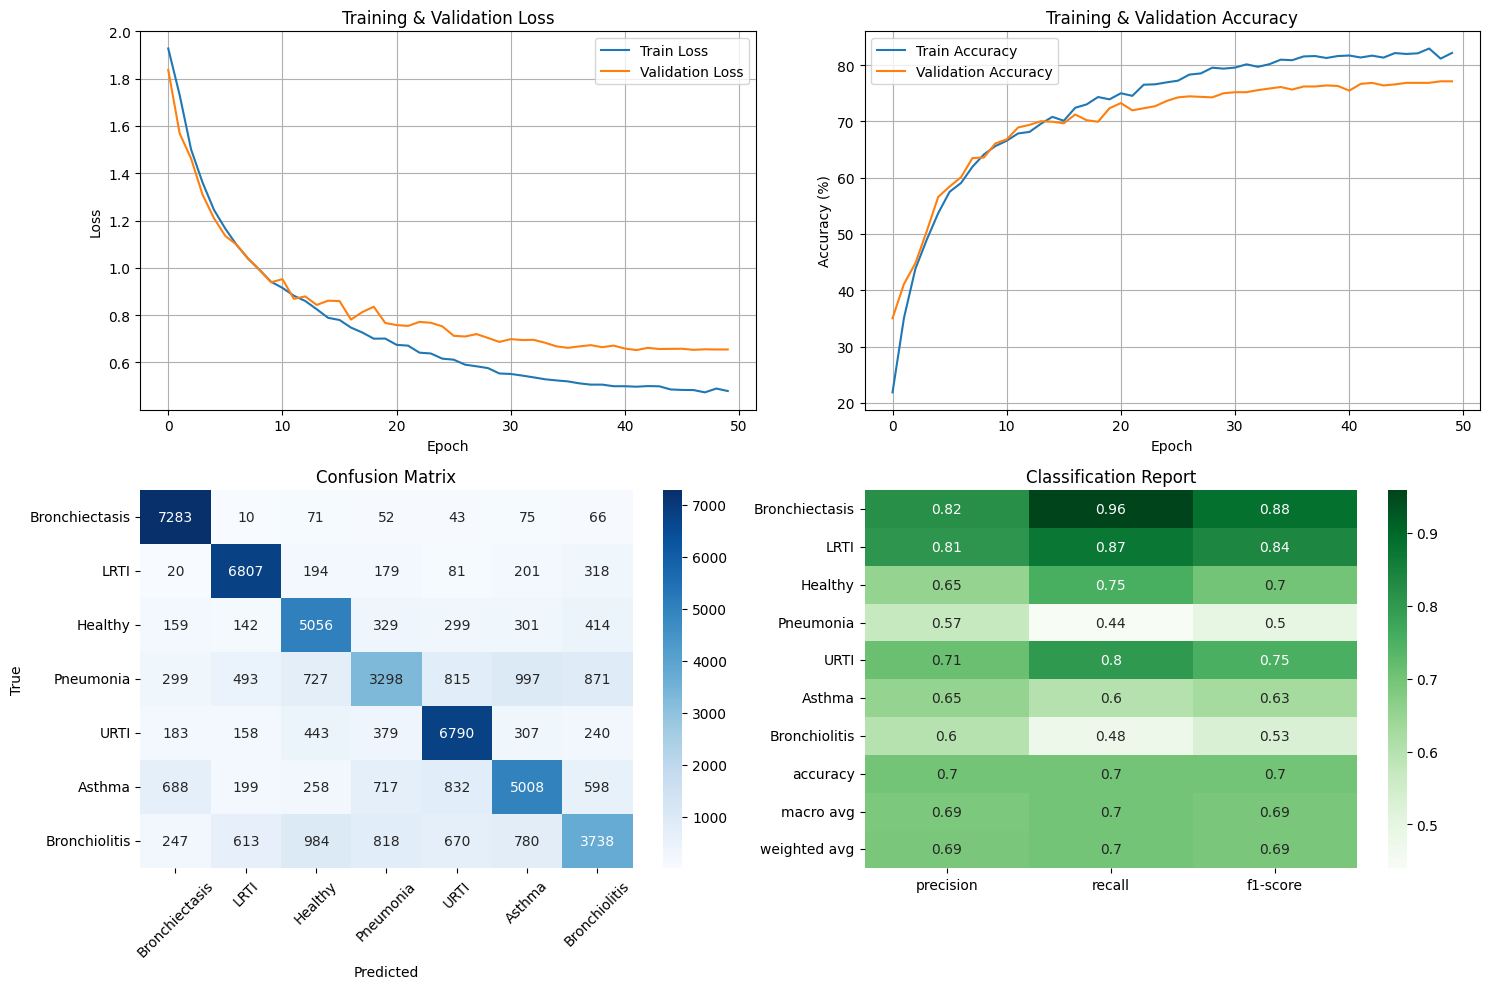

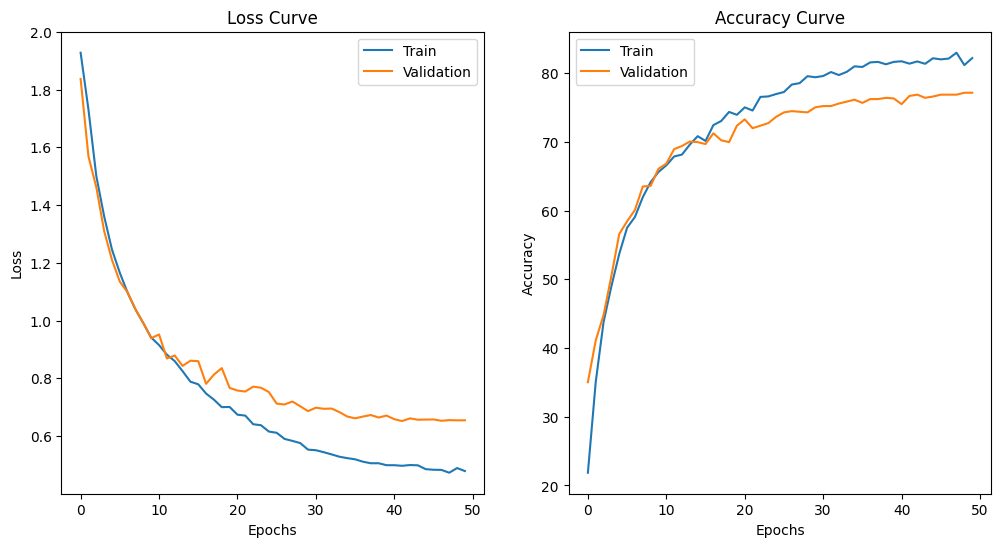

In [ ]:
# 2. Train with visualization
model, history = train_model_with_plots(
    train_dataset,
    val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=3e-5
)

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import numpy as np

def plot_roc_curve(true_labels, pred_probs, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve((true_labels == i).astype(int), pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.show()

# Get prediction probabilities for ROC curve
def get_pred_probs(model, data_loader, device):
    model.eval()
    all_probs = []
    all_true = []
    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_true.extend(labels.argmax(dim=1).cpu().numpy())
    return np.array(all_probs), np.array(all_true)

val_loader = DataLoader(val_dataset, batch_size=32)
pred_probs, true_labels = get_pred_probs(model, val_loader, device)
plot_roc_curve(true_labels, pred_probs, class_names=df_train['label'].unique())

In [ ]:
dataset = BreathDataset(df_train)  # Replace with your dataframe
dataloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)

In [ ]:
model = BreathClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


Using device: cuda


In [ ]:
# prompt: save the model and do some plots
num_epochs=20


# Plotting Loss and Accuracy
import matplotlib.pyplot as plt

# Example data (replace with your actual loss and accuracy values)
epochs = range(1, num_epochs + 1)
losses = []  # Replace with actual loss values from each epoch
accuracies = []  # Replace with actual accuracies

# ... Your training loop ...
# Inside the training loop, append the loss and accuracy for each epoch to the lists:

# Training loop
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    running_loss = 0.0
    model.train()

    for batch in dataloader:
        embeddings, mask, labels = batch
        embeddings = embeddings.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings, mask)  # shape: [batch_size, num_classes]

        loss = criterion(outputs, labels)  # labels: [batch_size]
        loss.backward()
        optimizer.step()

        predicted_labels = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)
        running_loss += loss.item()

    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}, Accuracy: {accuracy:.4f}, Loss: {running_loss:.4f}")

    # Append loss and accuracy for this epoch
    losses.append(running_loss / len(dataloader))  # Average loss for epoch
    accuracies.append(accuracy)
# Plotting

IndexError: tuple index out of range

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/breath_classifier_model_ICBHI2.pth')

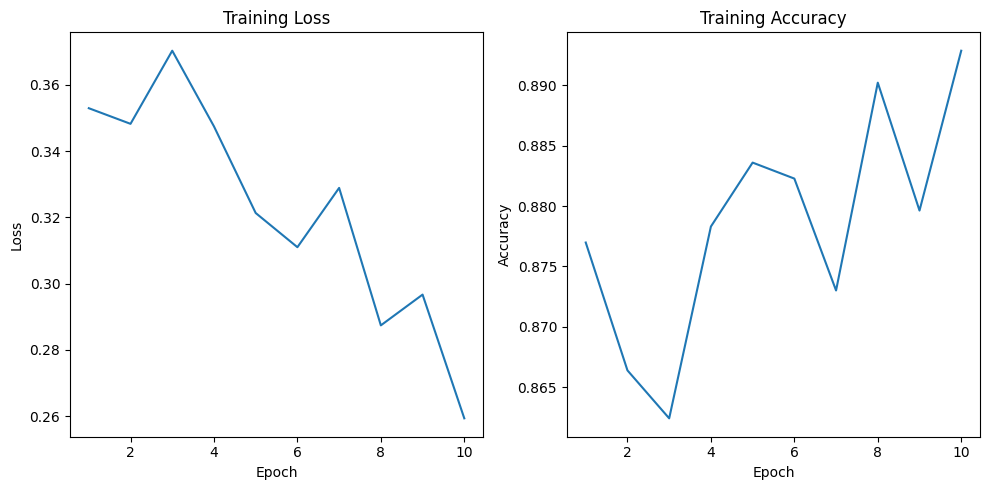

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


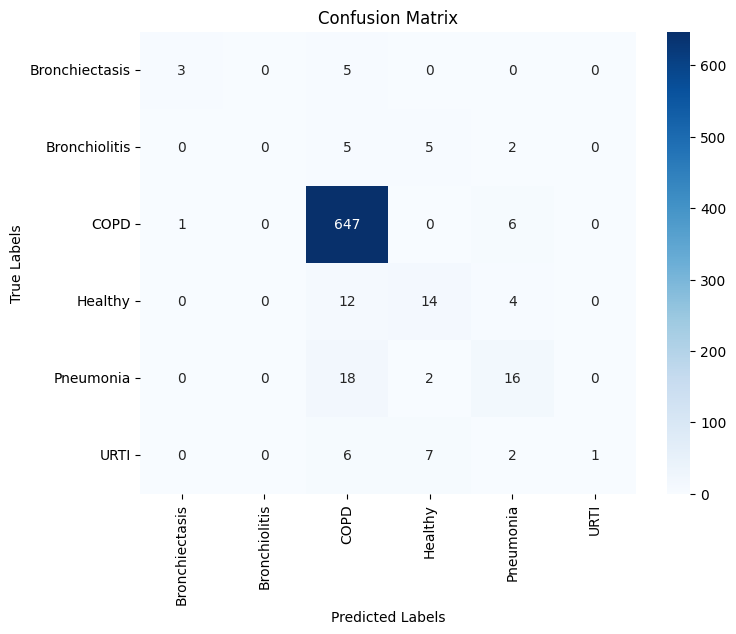

In [ ]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the entire dataset
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in dataloader:
        embeddings, mask, labels = batch
        embeddings = embeddings.to(device)
        mask = mask.to(device)
        outputs = model(embeddings, mask)
        predicted_labels = torch.argmax(outputs, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# # Generate Confusion Matrix
# cm = confusion_matrix(all_labels, all_predictions)

# # Plot using Seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.show()

## FPT Dataset

In [ ]:
mouth_embeddings ="/content/drive/MyDrive/breathe_mouth_embeddings/breathe_mouth"

In [ ]:
# prompt: open embeddings from folder and put into dataframe of file name and embedding column

import pandas as pd
import os
import numpy as np

def create_embedding_dataframe(embeddings_folder):


    if not os.path.isdir(embeddings_folder):
        print(f"Error: '{embeddings_folder}' is not a valid directory.")
        return None

    file_names = []
    embeddings = []

    for filename in os.listdir(embeddings_folder):
        if filename.endswith(".pt"):
            file_path = os.path.join(embeddings_folder, filename)
            try:
                embedding = torch.load(file_path)
                name_file = filename.split('_')[0].strip()
                file_names.append(name_file)
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error loading file '{filename}': {e}")

    if not file_names:
        print(f"No .pt files found in '{embeddings_folder}'.")
        return None

    df = pd.DataFrame({'label': file_names, 'embedding': embeddings})
    return df

# Example usage:
embeddings_folder = '/content/drive/MyDrive/breathe_mouth_embeddings/breathe_mouth'  # Replace with your folder path
df_mouth = create_embedding_dataframe(embeddings_folder)




In [ ]:
df_mouth.head()

,label,embedding
0,good,"[[[tensor(-0.2777), tensor(-0.1820), tensor(0...."
1,bad,"[[[tensor(-0.0562), tensor(-0.0547), tensor(0...."
2,good,"[[[tensor(-1.7816e-05), tensor(-0.2009), tenso..."
3,bad,"[[[tensor(-0.1162), tensor(-0.2193), tensor(0...."
4,good,"[[[tensor(-0.2763), tensor(-0.2212), tensor(0...."


In [ ]:
label_encoder = LabelEncoder()
df_mouth['label'] = label_encoder.fit_transform(df_mouth['label'])



['bad' 'good']


,label,embedding
0,2,"[[[-0.031339336, -0.0029167766, 0.07299463, -0..."
1,2,"[[[-0.05337552, -0.020015545, 0.08424821, -0.0..."
2,2,"[[[-0.115451805, 0.028835934, 0.0068247057, -0..."
3,2,"[[[-0.06628771, 0.07288514, -0.0011940964, -0...."
4,2,"[[[-0.06806382, -0.0049982863, 0.1136096, -0.0..."


In [ ]:
# Now df['label_encoded'] contains the numerical representation of your labels.
# You can access the mapping using label_encoder.classes_
print(label_encoder.classes_) # This will show you which number corresponds to which label
df_mouth.head()

['bad' 'good']


,label,embedding
0,1,"[[[tensor(-0.2777), tensor(-0.1820), tensor(0...."
1,0,"[[[tensor(-0.0562), tensor(-0.0547), tensor(0...."
2,1,"[[[tensor(-1.7816e-05), tensor(-0.2009), tenso..."
3,0,"[[[tensor(-0.1162), tensor(-0.2193), tensor(0...."
4,1,"[[[tensor(-0.2763), tensor(-0.2212), tensor(0...."


In [ ]:
class BreathDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding = np.array(self.data.iloc[idx]['embedding'][0])  # Shape (T, D)
        label_str = self.data.iloc[idx]['label']
        label = float(self.label_to_index[label_str])  # Ensure float for BCEWithLogitsLoss
        return torch.tensor(embedding, dtype=torch.float32), label

def collate_fn(batch):
    embeddings, labels = zip(*batch)
    lengths = [emb.shape[0] for emb in embeddings]
    max_len = max(lengths)
    d_model = embeddings[0].shape[1]

    padded_embeddings = torch.zeros(len(embeddings), max_len, d_model)
    attention_mask = torch.zeros(len(embeddings), max_len)

    for i, emb in enumerate(embeddings):
        padded_embeddings[i, :emb.shape[0], :] = emb
        attention_mask[i, :emb.shape[0]] = 1

    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1)
    return padded_embeddings, attention_mask, labels

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=6000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class BreathClassifier(torch.nn.Module):
    def __init__(self, d_model=768, nhead=8, dim_feedforward=3072, num_layers=2):
        super().__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(d_model, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1)  # Binary classification: 1 output logit
        )

    def forward(self, src, src_mask):
        src = self.pos_encoder(src)
        output = self.transformer(src, src_key_padding_mask=(src_mask == 0))
        masked_output = output * src_mask.unsqueeze(-1)
        pooled = masked_output.sum(dim=1) / src_mask.sum(dim=1, keepdim=True)
        return self.classifier(pooled)  # Shape: (batch_size, 1)

In [ ]:
dataset_fpt_mouth = BreathDataset(df_mouth)  # Replace with your dataframe
dataloader = DataLoader(dataset_fpt_mouth, batch_size=16, collate_fn=collate_fn, shuffle=True)

In [ ]:
model = BreathClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

Using device: cuda


In [ ]:
num_epochs=50


# Plotting Loss and Accuracy
import matplotlib.pyplot as plt

# Example data (replace with your actual loss and accuracy values)
epochs = range(1, num_epochs + 1)
losses = []
accuracies = []

for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    running_loss = 0.0
    model.train()

    for batch in dataloader:
        embeddings, mask, labels = batch
        embeddings = embeddings.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings, mask)  # Shape: (batch_size, 1)

        loss = criterion(outputs, labels)  # BCEWithLogitsLoss expects float32 labels of shape (B, 1)
        loss.backward()
        optimizer.step()

        # Convert logits to probabilities
        probs = torch.sigmoid(outputs)  # Shape: (batch_size, 1)
        predicted_labels = (probs > 0.5).long()  # Binary predictions: 0 or 1
        true_labels = labels.long()  # Convert labels to long for comparison

        correct_predictions += (predicted_labels == true_labels).sum().item()
        total_predictions += labels.size(0)
        running_loss += loss.item()

    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}, Accuracy: {accuracy:.4f}, Loss: {running_loss:.4f}")

    losses.append(running_loss / len(dataloader))
    accuracies.append(accuracy)


Epoch 1, Accuracy: 0.9779, Loss: 5.2039
Epoch 2, Accuracy: 0.9618, Loss: 8.2100
Epoch 3, Accuracy: 0.9824, Loss: 4.7825
Epoch 4, Accuracy: 0.9832, Loss: 3.9207
Epoch 5, Accuracy: 0.9794, Loss: 4.8239
Epoch 6, Accuracy: 0.9878, Loss: 2.8884
Epoch 7, Accuracy: 0.9901, Loss: 2.1055
Epoch 8, Accuracy: 0.9840, Loss: 4.0188
Epoch 9, Accuracy: 0.9878, Loss: 2.4370
Epoch 10, Accuracy: 0.9756, Loss: 4.4226
Epoch 11, Accuracy: 0.9870, Loss: 4.0002
Epoch 12, Accuracy: 0.9969, Loss: 0.8869
Epoch 13, Accuracy: 0.9977, Loss: 0.6566
Epoch 14, Accuracy: 0.9763, Loss: 5.4626
Epoch 15, Accuracy: 0.9893, Loss: 2.7227
Epoch 16, Accuracy: 0.9870, Loss: 2.7005
Epoch 17, Accuracy: 0.9878, Loss: 3.0255
Epoch 18, Accuracy: 0.9969, Loss: 0.7363
Epoch 19, Accuracy: 0.9969, Loss: 0.4152
Epoch 20, Accuracy: 0.9885, Loss: 2.8285
Epoch 21, Accuracy: 0.9870, Loss: 3.9095
Epoch 22, Accuracy: 0.9992, Loss: 0.2891
Epoch 23, Accuracy: 1.0000, Loss: 0.0635
Epoch 24, Accuracy: 1.0000, Loss: 0.0245
Epoch 25, Accuracy: 1.000

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/breath_classifier_model_FPT_mouth.pth')

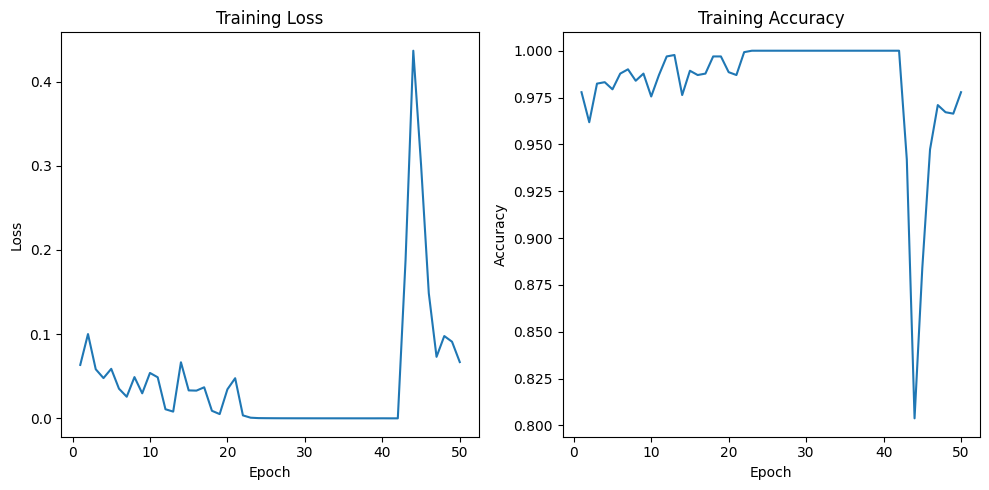

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the entire dataset
all_predictions = []
all_labels = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in dataloader:
        embeddings, mask, labels = batch
        embeddings = embeddings.to(device)
        mask = mask.to(device)
        outputs = model(embeddings, mask)
        predicted_labels = torch.argmax(outputs, dim=1)

        all_predictions.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

